In [94]:
import sys
sys.path.insert(0, '../')

# sys.path.remove("/home/users/yixiuz/.local/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/bin")

In [133]:
from importlib import reload

reload(piano)
reload(sampling_utils)
reload(sampling)

<module 'lib.sampling.sampling' from '../lib/sampling/sampling.py'>

In [134]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import ml_collections

import config.eval.piano_hollow as piano
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.utils.utils as utils
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils

%matplotlib inline

eval_cfg = piano.get_config()
train_cfg = bookkeeping.load_ml_collections(Path(eval_cfg.train_config_path))

for item in eval_cfg.train_config_overrides:
    utils.set_in_nested_dict(train_cfg, item[0], item[1])

S = train_cfg.data.S
# device = torch.device(eval_cfg.device)
device = torch.device("cuda")

model = model_utils.create_model(train_cfg, device)

loaded_state = torch.load(Path(eval_cfg.checkpoint_path),
    map_location=device)

modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
model.load_state_dict(modified_model_state)

model.eval()

dataset = dataset_utils.get_dataset(eval_cfg, device)
data = dataset.data
test_dataset = np.load(eval_cfg.sampler.test_dataset)
condition_dim = eval_cfg.sampler.condition_dim
descramble_key = np.loadtxt(eval_cfg.pianoroll_dataset_path + '/descramble_key.txt')
# The mask stays the same
descramble_key = np.concatenate([descramble_key, np.array([descramble_key.shape[0]])], axis=0)

def descramble(samples):
    return descramble_key[samples.flatten()].reshape(*samples.shape)

descrambled_test_dataset = descramble(test_dataset)

In [135]:
data.shape

torch.Size([6000, 256])

In [188]:
# -------------- Sample the model ------------------
num_samples = 5
test_data_idx = 2
conditioner = torch.from_numpy(test_dataset[test_data_idx, 0:condition_dim]).to(device).view(1, condition_dim)
conditioner = conditioner.repeat(num_samples, 1)

# play around with the sampler by overriding some configs
eval_cfg.sampler.balancing_function = "birthdeath"
eval_cfg.sampler.corrector_step_size_multiplier = 1.

sampler = sampling_utils.get_sampler(eval_cfg)
# sampler = ConditionalTauLeaping(eval_cfg)
samples, hist = sampler.sample(model, num_samples, 100, conditioner)
x_hist, x0_hist = hist["x"], hist["x0"]
samples, x_hist, x0_hist = descramble(samples), descramble(x_hist), descramble(x0_hist)


999it [00:27, 36.85it/s]


In [169]:
sampler

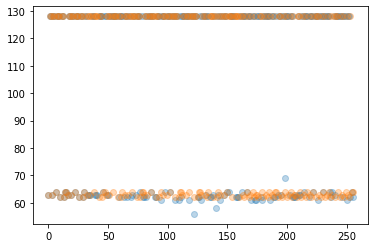

In [189]:
idx = 0
plt.scatter(np.arange(256), samples[0, :], alpha=0.3)
# plt.scatter(np.arange(256), samples[1, :], alpha=0.3)
# plt.scatter(np.arange(256), samples[2, :], alpha=0.3)
plt.scatter(np.arange(256), descrambled_test_dataset[test_data_idx, :], alpha=0.3)
plt.show()

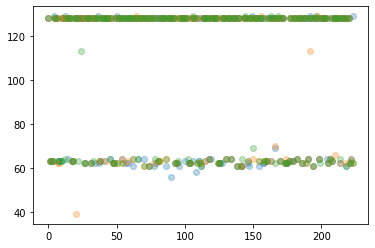

In [190]:
t = 99
plt.scatter(np.arange(224), x_hist[t, 0], alpha=0.3)
plt.scatter(np.arange(224), x_hist[t, 1], alpha=0.3)
plt.scatter(np.arange(224), x_hist[t, 2], alpha=0.3)

In [196]:
def get_dist(seq):
    S = 129
    L = seq.shape[0]
    one_hot = np.zeros((L, S))
    seq = np.array(seq, dtype=int)
    one_hot[np.arange(L), seq] = 1
    return np.sum(one_hot, axis=0) / L

def get_mask(seq):
    S = 129
    L = seq.shape[0]
    one_hot = np.zeros((L, S))
    seq = np.array(seq, dtype=int)
    one_hot[np.arange(L), seq] = 1
    return 1 - np.prod(1 - one_hot, axis=0)

def hellinger(seq1, seq2):
    d1, d2 = get_dist(seq1), get_dist(seq2)
    return np.sqrt(.5 * np.sum((d1 ** .5 - d2 ** .5) ** 2))

def outliers(ref, sample):
    ref_mask = get_mask(ref)
    sample_dist = get_dist(sample)
    return np.sum((1 - ref_mask) * sample_dist)

# Is hellinger distance really a good metric??
# WTH is going on in here...???
print(hellinger(samples[4, condition_dim:], descrambled_test_dataset[test_data_idx, condition_dim:]))
print(outliers(descrambled_test_dataset[test_data_idx, condition_dim:], samples[4,condition_dim:]))

0.21007508868326227
0.053571428571428575


In [106]:
print(hellinger(samples[4, condition_dim:], descrambled_test_dataset[test_data_idx, condition_dim:]))
print(outliers(samples[4, condition_dim:], descrambled_test_dataset[test_data_idx, condition_dim:]))

0.13681576756558134
0.0


# Sample one sequence for each test data

In [197]:
device

device(type='cuda')

In [199]:
batch_size = 100

eval_cfg.sampler.name = "ConditionalPCTauLeapingAbsorbingInformed"
eval_cfg.sampler.balancing_function = "birthdeath"
eval_cfg.sampler.num_steps = 500
eval_cfg.sampler.corrector_step_size_multiplier = 0.5

sampler = sampling_utils.get_sampler(eval_cfg)
test_size = test_dataset.shape[0]
h_dists = []
outlier_proportions = []
for start in range(0, test_size, batch_size):
    print(start)
    end = min(start + batch_size, test_size)
    size = end - start
    
    conditioner = torch.from_numpy(test_dataset[start:end, :condition_dim]).to(device)
    samples, _ = sampler.sample(model, size, 1, conditioner)
    samples = descramble(samples)

    for i in range(size):
        h = hellinger(descrambled_test_dataset[start+i, :], samples[i, :])
        r = outliers(descrambled_test_dataset[start+i, :], samples[i, :])
        h_dists.append(h)
        outlier_proportions.append(r)
        
    print("batch:", np.mean(h_dists), np.mean(outlier_proportions))
        
print(eval_cfg.sampler.name)
print("Hellinger distance", np.mean(h_dists))
print("Proportion of outliers", np.mean(outlier_proportions))

0


499it [00:48, 10.21it/s]


batch: 0.37881937103798263 0.1253125
100


499it [00:48, 10.21it/s]


batch: 0.3770710202562641 0.12296875
200


499it [00:48, 10.21it/s]


batch: 0.37878769258744777 0.12365885416666667
300


499it [00:48, 10.21it/s]


batch: 0.3805281908536221 0.12560546875
400


499it [00:48, 10.21it/s]


batch: 0.37972148146854157 0.1244296875
500


499it [00:48, 10.19it/s]


batch: 0.38094907855957916 0.12626953125
600


499it [00:48, 10.19it/s]


batch: 0.37927564373684003 0.12423549107142857
700


499it [00:49, 10.18it/s]


batch: 0.3804219829757048 0.127724609375
800


499it [00:49, 10.18it/s]


batch: 0.3782656205106633 0.1260546875
900


499it [00:37, 13.34it/s]

batch: 0.38169927766269196 0.12765368062692703
ConditionalPCTauLeapingAbsorbingInformed
Hellinger distance 0.38169927766269196
Proportion of outliers 0.12765368062692703


In [155]:
# This matches the number reported in the paper
np.mean(h_dists)

0.3776880176747058

In [156]:
# And so does this...!
np.mean(outlier_proportions)

0.11121772225077081